COLAB LINK: https://colab.research.google.com/drive/1DXKVIapgSKXVtob5D2Xjf7g6-rPuHKGr?usp=sharing

Relevant articles links for future reference:
1. https://nandakishorej8.medium.com/auto-tuning-multiple-timeseries-sarimax-model-with-a-case-study-and-detailed-code-explanation-c136293b8457

2. https://medium.com/@mertsukrupehlivan/mastering-time-series-forecasting-a-guide-to-hyperparameter-tuning-for-sarimax-models-b4a84062cba3

3. https://towardsdatascience.com/grid-search-for-sarimax-parameters-adbd5104cb8b

4. Dataset link: https://drive.google.com/file/d/1MjDU2lSYtFxGEpjXNZL_j99tBt3zy1-J/view?usp=sharing

This notebook contains code for time series forecasting using Sarimax and Facebook Prophet model on a weekly time series dataset.

#DATA LOADING, EDA, AND TRANSFORMATIONS

In [ ]:
# prompt: read pd  from cs v file

import pandas as pd
df = pd.read_csv('/content/Insight_Reports_Fiver_Property2.csv')


In [ ]:
df.shape

(1315, 20)

In [ ]:
df.dropna(axis=1,how='all',inplace=True)

df['Check In'] = pd.to_datetime(df['Check In'],format='%d/%m/%Y %H:%M')
df['Check Out'] = pd.to_datetime(df['Check Out'],format='%d/%m/%Y %H:%M')

df.sort_values(by='Check In',inplace=True)
columns_to_drop=['ID', 'Group ID', 'Status', 'Created', 'Last Updated','Fees','Paid']
df.drop(columns_to_drop,axis=1,inplace=True)

df['Nights'] = df['Nights'].str.extract('([\d\.]+)', expand=False).astype(float)
#as each row represents a booking so adding a colimn to count
df['Number_of_Bookings']=1




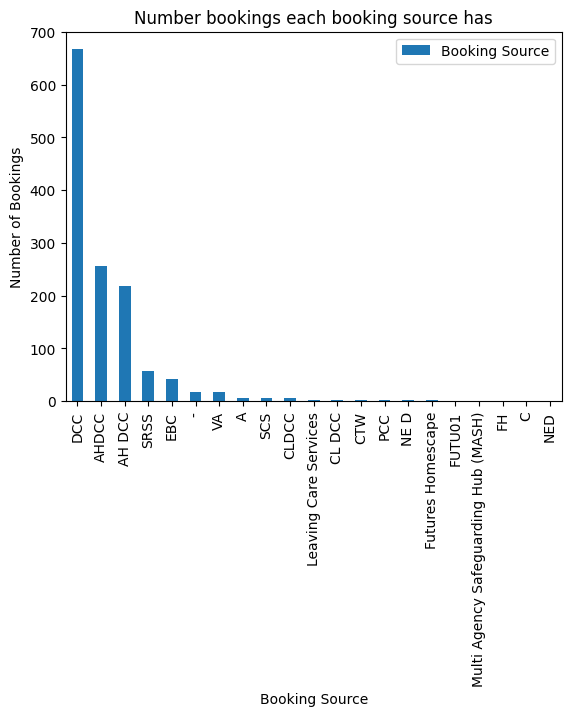

In [ ]:
import matplotlib.pyplot as plt

#plotting graph for Number of bookings each Booking Source has
df['Booking Source'].value_counts().plot( kind='bar', title='Number bookings each booking source has' )
plt.legend(loc="upper right")
plt.xlabel("Booking Source")
plt.ylabel("Number of Bookings")
plt.show()


In [ ]:

#remove rows with 0 total
df=df[df['Booking']!=0]


In [ ]:

#one hot encoding booking source column
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df['Booking Source'].values.reshape(-1,1))
cats=['Booking_source_' + sub for sub in enc.categories_ ]
cc=pd.DataFrame(enc.transform(df['Booking Source'].values.reshape(-1,1)).toarray(),columns=cats)
df=df.join(cc)
df.drop(['Booking Source'],axis=1, inplace=True)
del cc

df.drop(['Check Out','Room'],axis=1,inplace=True)
daily_records=df.groupby('Check In').sum()
#daily_records.columns
daily_records.drop(['Total','Owing'],axis=1,inplace=True)


In [ ]:
daily_records.reset_index(inplace=True)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

# Assuming daily_records is your DataFrame
# Rename columns to normal words
daily_records.columns = [
    'Check_In', 'Nights', 'Guest', 'Booking', 'Number_of_Bookings',
    'Booking_source_minus', 'Booking_source_A', 'Booking_source_AH_DCC', 'Booking_source_AHDCC',
    'Booking_source_C', 'Booking_source_CL_DCC', 'Booking_source_CLDCC', 'Booking_source_CTW',
    'Booking_source_DCC', 'Booking_source_EBC', 'Booking_source_FH','Booking_source_FUTU01', 'Booking_source_Futures_Homescape',
    'Booking_source_Leaving_Care_Services', 'Booking_source_Multi_Agency_Safeguarding_Hub_MASH',
    'Booking_source_NE_D','Booking_source_NED','Booking_source_PCC', 'Booking_source_SCS', 'Booking_source_SRSS', 'Booking_source_VA'
]
daily_records.columns = daily_records.columns.astype(str)


In [ ]:
# Assuming daily_records is your DataFrame containing the booking data

# Step 1: Preprocess the data
# Ensure 'Check_In' is datetime index
daily_records['Check_In'] = pd.to_datetime(daily_records['Check_In'])
daily_records.set_index('Check_In', inplace=True)

# TRAIN TEST SPLIT

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

daily_records.index = pd.to_datetime(daily_records.index)

# Resample the DataFrame index to weekly frequency and aggregate the values using sum
daily_records = daily_records.resample('W').sum()

# Reset index to make 'Check_In' a column again
daily_records.reset_index(inplace=True)

daily_records.set_index("Check_In", inplace=True)

train_size = int(0.8 * len(daily_records))
train_data = daily_records.iloc[:train_size]
test_data = daily_records.iloc[train_size:]

# FINE TUNING SARIMAX MODEL PARAMETERS

You can use this code to either fine tune on `train_data['Booking']` or on `train_data['Number_of_Bookings']`, and then use the best parameters in the later cells

In [ ]:
def grid_search_sarimax(train_data, test_data):
    """
    Perform grid search to find the best SARIMAX parameters.

    Args:
    - train_data (pd.DataFrame): Training data for SARIMAX model.
    - test_data (pd.DataFrame): Test data for SARIMAX model.

    Returns:
    - tuple: Best parameters found and the corresponding RMSE.
    """

    # Define the range of parameters to search
    p = range(3)  # Range of AR component
    d = range(2)  # Range of differencing
    q = range(2)  # Range of MA component
    P = range(3)  # Range of seasonal AR component
    D = range(2)  # Range of seasonal differencing
    Q = range(2)  # Range of seasonal MA component
    s = [12]  # Seasonal periodicity (monthly data)

    # Create a list of all parameter combinations
    param_combinations = list(product(p, d, q, P, D, Q, s))

    # Initialize variables to store best parameters and minimum RMSE
    best_params = None
    min_rmse = float('inf')

    # Iterate over each parameter combination
    for param in param_combinations:
        # Unpack the parameter values
        p, d, q, P, D, Q, s = param

        # Train SARIMAX model with current parameter combination
        model = SARIMAX(train_data['Booking'], order=(p, d, q), seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False, enforce_invertibility=False)
        sarimax_model = model.fit()

        # Make predictions
        start_idx = len(train_data)
        end_idx = len(train_data) + len(test_data) - 1
        forecast = sarimax_model.predict(start=start_idx, end=end_idx, dynamic=False)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(test_data['Booking'], forecast))

        # Update best parameters if current RMSE is lower
        if rmse < min_rmse:
            min_rmse = rmse
            best_params = param

    return best_params, min_rmse



# Usage example:
best_params, min_rmse = grid_search_sarimax(train_data['Booking'], test_data['Booking'])
# best_params, min_rmse = grid_search_sarimax(train_data['Number_of_Bookings'], test_data['Number_of_Bookings'])
print("Best parameters:", best_params)
print("Minimum RMSE:", min_rmse)


# TRAINING SARIMAX WITH BOOKING COLUMN ON FINE TUNED PARAMETERS FROM ABOVE

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 3: Train the SARIMAX model with the best parameters now
order = (1, 0, 0)
seasonal_order = (2, 0, 1, 12)
model = SARIMAX(train_data['Booking'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarimax_model = model.fit()

# Step 4: Make predictions
start_idx = len(train_data)
end_idx = len(train_data) + len(test_data) - 1
forecast = sarimax_model.predict(start=start_idx, end=end_idx, dynamic=False)

rmse = np.sqrt(mean_squared_error(test_data['Booking'], forecast))
print("Root Mean Squared Error (RMSE):", rmse)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



Root Mean Squared Error (RMSE): 1890.0810942960252


In [ ]:
import plotly.graph_objs as go

trace_actual = go.Scatter(x=test_data.index, y=test_data['Booking'], mode='lines', name='Actual', line=dict(color='blue'))
trace_predicted = go.Scatter(x=test_data.index, y=forecast, mode='lines', name='Predicted Bookings', line=dict(color='red'))
layout_predicted = go.Layout(title='Actual vs Predicted Bookings', xaxis=dict(title='Date'), yaxis=dict(title='Booking'))
fig_predicted = go.Figure(data=[trace_actual, trace_predicted], layout=layout_predicted)
fig_predicted.show()


In [ ]:
import plotly.graph_objs as go

future_start_date = '2024-01-01'
future_end_date_weekly = pd.date_range(start=future_start_date, periods=54, freq='W')

# Forecast for 54 weeks after January 2024 (weekly)
future_forecast_weekly = sarimax_model.forecast(steps=54)

# Create traces
trace_actual = go.Scatter(x=test_data.index, y=test_data['Booking'], mode='lines', name='Actual', line=dict(color='blue'))
trace_weekly_forecast = go.Scatter(x=future_end_date_weekly, y=future_forecast_weekly, mode='lines', name='Forecast (Weekly)', line=dict(color='green'))
layout_weekly = go.Layout(title='Forecast after January 2024 (Weekly)', xaxis=dict(title='Date'), yaxis=dict(title='Booking'))
fig_weekly = go.Figure(data=[trace_actual, trace_weekly_forecast], layout=layout_weekly)
fig_weekly.show()


In [ ]:
import plotly.graph_objs as go

# Define the future start date for weekly forecasts (January 2024)
future_start_date = '2024-01-01'

# Forecast for 52 weeks after January 2024 (weekly)
future_forecast_weekly = sarimax_model.forecast(steps=52)

# Generate the future date range for weekly forecasts
future_end_date_weekly = pd.date_range(start=future_start_date, periods=52, freq='W')

# Resample the weekly forecasted values to monthly frequency by calculating the sum
future_forecast_monthly = future_forecast_weekly.resample('M').sum()

# Generate the future date range for monthly forecasts (January 2024 to December 2024)
future_end_date_monthly = pd.date_range(start='2024-01-01', end='2024-12-31', freq='MS')

# Create trace for monthly forecast
trace_monthly_forecast = go.Scatter(x=future_end_date_monthly, y=future_forecast_monthly, mode='lines', name='Forecast (Monthly)', line=dict(color='red'))

# Create layout for the plot
layout_monthly = go.Layout(title='Forecast for 2024 (Monthly)', xaxis=dict(title='Date'), yaxis=dict(title='Total Booking'))

# Create figure
fig_monthly = go.Figure(data=[trace_monthly_forecast], layout=layout_monthly)

# Show the plot
fig_monthly.show()


In [ ]:
import plotly.graph_objs as go

# Define the future start date for weekly forecasts (January 2024)
future_start_date = '2024-01-01'

# Forecast for 260 weeks after January 2024 (weekly)
future_forecast_weekly = sarimax_model.forecast(steps=52 * 5)

# Generate the future date range for weekly forecasts
future_end_date_weekly = pd.date_range(start=future_start_date, periods=52 * 5, freq='W')

# Resample the weekly forecasted values to monthly frequency by calculating the sum
future_forecast_monthly = future_forecast_weekly.resample('M').sum()

# Generate the future date range for monthly forecasts
future_end_date_monthly = pd.date_range(start='2024-01-01', periods=60, freq='MS')  # 5 years * 12 months = 60 months

# Resample the monthly forecasted values to yearly frequency by calculating the sum
future_forecast_yearly = future_forecast_monthly.resample('Y').sum()

# Generate the future date range for yearly forecasts
future_end_date_yearly = pd.date_range(start='2024-01-01', periods=5, freq='Y')  # 5 years

# Create trace for yearly forecast
trace_yearly_forecast = go.Scatter(x=future_end_date_yearly, y=future_forecast_yearly, mode='lines', name='Forecast (Yearly)', line=dict(color='blue'))

# Create layout for the plot
layout_yearly = go.Layout(title='Forecast for the Next 5 Years after 2024', xaxis=dict(title='Year'), yaxis=dict(title='Total Booking'))

# Create figure
fig_yearly = go.Figure(data=[trace_yearly_forecast], layout=layout_yearly)

# Show the plot
fig_yearly.show()


#  TRAINING SARIMAX WITH NUMBER OF BOOKINGS COLUMN ON FINE TUNED PARAMETERS FROM ABOVE

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np


# Step 3: Train the SARIMAX model on fine tuned parameters
order = (1, 0, 0)
seasonal_order = (2, 1, 1, 12)

model = SARIMAX(train_data['Number_of_Bookings'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarimax_model = model.fit()

# Step 4: Make predictions
start_idx = len(train_data)
end_idx = len(train_data) + len(test_data) - 1
forecast = sarimax_model.predict(start=start_idx, end=end_idx, dynamic=False)

rmse = np.sqrt(mean_squared_error(test_data['Number_of_Bookings'], forecast))
print("Root Mean Squared Error (RMSE):", rmse)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



Root Mean Squared Error (RMSE): 1.529465186865385


In [ ]:
import plotly.graph_objs as go

trace_actual = go.Scatter(x=test_data.index, y=test_data['Number_of_Bookings'], mode='lines', name='Actual', line=dict(color='blue'))
trace_predicted = go.Scatter(x=test_data.index, y=forecast, mode='lines', name='Predicted Number_of_Bookings', line=dict(color='red'))
layout_predicted = go.Layout(title='Actual vs Predicted Number_of_Bookings', xaxis=dict(title='Date'), yaxis=dict(title='Number_of_Bookings'))
fig_predicted = go.Figure(data=[trace_actual, trace_predicted], layout=layout_predicted)
fig_predicted.show()


In [ ]:
import plotly.graph_objs as go

future_start_date = '2024-01-01'
future_end_date_weekly = pd.date_range(start=future_start_date, periods=54, freq='W')

# Forecast for 54 weeks after January 2024 (weekly)
future_forecast_weekly = sarimax_model.forecast(steps=54)

# Create traces
trace_actual = go.Scatter(x=test_data.index, y=test_data['Number_of_Bookings'], mode='lines', name='Actual', line=dict(color='blue'))
trace_weekly_forecast = go.Scatter(x=future_end_date_weekly, y=future_forecast_weekly, mode='lines', name='Forecast (Weekly)', line=dict(color='green'))
layout_weekly = go.Layout(title='Forecast after January 2024 (Weekly)', xaxis=dict(title='Date'), yaxis=dict(title='Number_of_Bookings'))
fig_weekly = go.Figure(data=[trace_actual, trace_weekly_forecast], layout=layout_weekly)
fig_weekly.show()



In [ ]:
import plotly.graph_objs as go

# Define the future start date for weekly forecasts (January 2024)
future_start_date = '2024-01-01'

# Forecast for 52 weeks after January 2024 (weekly)
future_forecast_weekly = sarimax_model.forecast(steps=52)

# Generate the future date range for weekly forecasts
future_end_date_weekly = pd.date_range(start=future_start_date, periods=52, freq='W')

# Resample the weekly forecasted values to monthly frequency by calculating the sum
future_forecast_monthly = future_forecast_weekly.resample('M').sum()

# Generate the future date range for monthly forecasts (January 2024 to December 2024)
future_end_date_monthly = pd.date_range(start='2024-01-01', end='2024-12-31', freq='MS')

# Create trace for monthly forecast
trace_monthly_forecast = go.Scatter(x=future_end_date_monthly, y=future_forecast_monthly, mode='lines', name='Forecast (Monthly)', line=dict(color='red'))

# Create layout for the plot
layout_monthly = go.Layout(title='Forecast for 2024 (Monthly)', xaxis=dict(title='Date'), yaxis=dict(title='Total Number_of_Bookings'))

# Create figure
fig_monthly = go.Figure(data=[trace_monthly_forecast], layout=layout_monthly)

# Show the plot
fig_monthly.show()


In [ ]:
import plotly.graph_objs as go

# Define the future start date for weekly forecasts (January 2024)
future_start_date = '2024-01-01'

# Forecast for 260 weeks after January 2024 (weekly)
future_forecast_weekly = sarimax_model.forecast(steps=52 * 5)

# Generate the future date range for weekly forecasts
future_end_date_weekly = pd.date_range(start=future_start_date, periods=52 * 5, freq='W')

# Resample the weekly forecasted values to monthly frequency by calculating the sum
future_forecast_monthly = future_forecast_weekly.resample('M').sum()

# Generate the future date range for monthly forecasts
future_end_date_monthly = pd.date_range(start='2024-01-01', periods=60, freq='MS')  # 5 years * 12 months = 60 months

# Resample the monthly forecasted values to yearly frequency by calculating the sum
future_forecast_yearly = future_forecast_monthly.resample('Y').sum()

# Generate the future date range for yearly forecasts
future_end_date_yearly = pd.date_range(start='2024-01-01', periods=5, freq='Y')  # 5 years

# Create trace for yearly forecast
trace_yearly_forecast = go.Scatter(x=future_end_date_yearly, y=future_forecast_yearly, mode='lines', name='Forecast (Yearly)', line=dict(color='blue'))

# Create layout for the plot
layout_yearly = go.Layout(title='Forecast for the Next 5 Years after 2024', xaxis=dict(title='Year'), yaxis=dict(title='Total Number_of_Bookings'))

# Create figure
fig_yearly = go.Figure(data=[trace_yearly_forecast], layout=layout_yearly)

# Show the plot
fig_yearly.show()


# FB PROPHET WITH GRID SEARCH CV

## Install prophet

In [ ]:
!pip install prophet


## Prepare data for Prophet

In [ ]:
import prophet as Prophet
from sklearn.metrics import mean_squared_error
import numpy as np

# Define a function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Prepare data for Prophet
prophet_data = daily_records.reset_index()[['Check_In', 'Booking']]
prophet_data.columns = ['ds', 'y']  # Rename columns as required by Prophet

# Train-test split
train_size = int(0.8 * len(prophet_data))
train_data = prophet_data.iloc[:train_size]
test_data = prophet_data.iloc[train_size:]

## Create a parameter dictionary

In [ ]:

# Define parameter grid
param_grid = {
    'yearly_seasonality': [True, False],
    'changepoint_prior_scale': [0.05, 0.1, 0.5, 1.0],
    'seasonality_prior_scale': [0.1, 1.0, 10.0, 12.0, 15.0]
}

## Optimize!

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpalu9y8f5/ny_k1awq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpalu9y8f5/yuozz5pq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73046', 'data', 'file=/tmp/tmpalu9y8f5/ny_k1awq.json', 'init=/tmp/tmpalu9y8f5/yuozz5pq.json', 'output', 'file=/tmp/tmpalu9y8f5/prophet_modelsxev81v_/prophet_model-20240312191706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:17:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:17:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpal

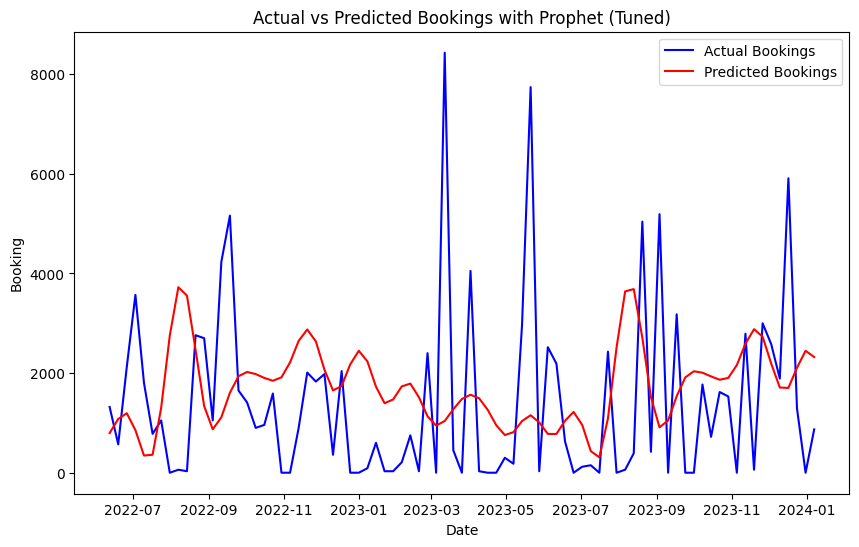

Best Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}
Root Mean Squared Error (RMSE) with Prophet (Tuned): 2050.3563686555776


In [ ]:
best_rmse = float('inf')
best_params = {}

# Perform grid search
for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
    for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
        # Initialize Prophet model with current parameters
        model = Prophet.Prophet(weekly_seasonality= True,
            yearly_seasonality=True,
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale
        )
        try:
            # Fit the model
            model.fit(train_data)

            # Make predictions
            future = model.make_future_dataframe(periods=len(test_data), freq='W')
            forecast = model.predict(future)

            # Calculate RMSE
            rmse = calculate_rmse(test_data['y'], forecast['yhat'].tail(len(test_data)))

            # Update best parameters if RMSE is improved
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = {
                    'changepoint_prior_scale': changepoint_prior_scale,
                    'seasonality_prior_scale': seasonality_prior_scale
                }
        except Exception as e:
            print(f"An error occurred with parameters: {best_params}. Error: {e}")

# Re-train the model with the best parameters
model = Prophet.Prophet(weekly_seasonality=True, daily_seasonality=True, yearly_seasonality=True, **best_params)
model.fit(train_data)

# Make predictions
future = model.make_future_dataframe(periods=len(test_data), freq='W')
forecast = model.predict(future)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual Bookings', color='blue')
plt.plot(test_data['ds'], forecast['yhat'].tail(len(test_data)), label='Predicted Bookings', color='red')
plt.title('Actual vs Predicted Bookings with Prophet (Tuned)')
plt.xlabel('Date')
plt.ylabel('Booking')
plt.legend()
plt.show()


# Print best parameters and RMSE
print("Best Parameters:", best_params)
print("Root Mean Squared Error (RMSE) with Prophet (Tuned):", best_rmse)


# FBPROPHET WITHOUT GRID SEARCH CV

In [ ]:
import prophet as Prophet
from sklearn.metrics import mean_squared_error
import numpy as np

# Define a function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Prepare data for Prophet
prophet_data = daily_records.reset_index()[['Check_In', 'Booking']]
prophet_data.columns = ['ds', 'y']  # Rename columns as required by Prophet

# Train-test split
train_size = int(0.8 * len(prophet_data))
train_data = prophet_data.iloc[:train_size]
test_data = prophet_data.iloc[train_size:]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpalu9y8f5/uibmbfic.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpalu9y8f5/s9w69dhb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88425', 'data', 'file=/tmp/tmpalu9y8f5/uibmbfic.json', 'init=/tmp/tmpalu9y8f5/s9w69dhb.json', 'output', 'file=/tmp/tmpalu9y8f5/prophet_modelb3ygyjxx/prophet_model-20240312191808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:18:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:18:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


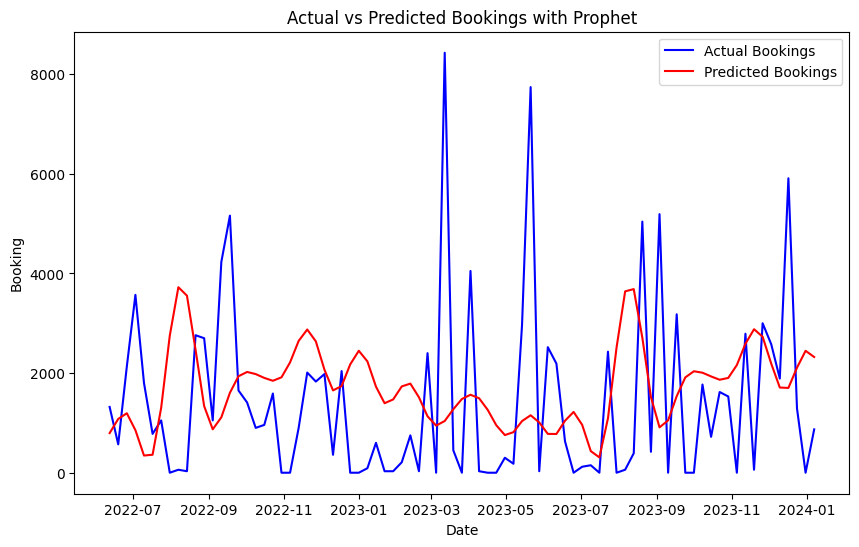

Root Mean Squared Error (RMSE) with Prophet: 2050.3563686555776


In [ ]:
# Re-train the model with the tuned parameters
model = Prophet.Prophet(weekly_seasonality=True,
                changepoint_prior_scale=0.1,
                seasonality_prior_scale=0.1)

# Train the model
model.fit(train_data)

# Make predictions
future = model.make_future_dataframe(periods=len(test_data), freq='W')
forecast = model.predict(future)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual Bookings', color='blue')
plt.plot(test_data['ds'], forecast['yhat'].tail(len(test_data)), label='Predicted Bookings', color='red')
plt.title('Actual vs Predicted Bookings with Prophet')
plt.xlabel('Date')
plt.ylabel('Booking')
plt.legend()
plt.show()

# Print best parameters and RMSE
print("Root Mean Squared Error (RMSE) with Prophet:", calculate_rmse(test_data['y'], forecast['yhat'].tail(len(test_data))))


In [ ]:
### Just a helper function for me, you can ignore it

# Define the start and end dates
start_date = '2022-06-05'
end_date = '2024-01-07'

# Create a date range between the two dates with a weekly frequency
weeks_between_dates = pd.date_range(start=start_date, end=end_date, freq='W')

# Calculate the number of weeks
num_weeks = len(weeks_between_dates)

print("Number of weeks between", start_date, "and", end_date, ":", num_weeks)


Number of weeks between 2022-06-05 and 2024-01-07 : 84


In [ ]:
import plotly.graph_objs as go

# Make predictions starting from 2022-06-05
weekly = model.make_future_dataframe(periods=84+54, include_history=False, freq='W')
forecast = model.predict(weekly)
forecast = forecast.tail(55)

# Create trace for the forecasted values
trace_forecast = go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast')

# Create layout for the plot
layout = go.Layout(title='Forecast over Weeks', xaxis=dict(title='Date'), yaxis=dict(title='Forecasted Value'))

# Create figure
fig = go.Figure(data=[trace_forecast], layout=layout)

# Show the plot
fig.show()


In [ ]:
forecast.set_index("ds", inplace=True)
monthly_forecast = forecast.resample('M').sum()


# Create trace for the monthly forecasted values
trace_monthly_forecast = go.Scatter(x=monthly_forecast.index, y=monthly_forecast['yhat'], mode='lines', name='Monthly Forecast')

# Create layout for the plot
layout_monthly = go.Layout(title='Monthly Forecast for 2024', xaxis=dict(title='Date'), yaxis=dict(title='Forecasted Value'))

# Create figure
fig_monthly = go.Figure(data=[trace_monthly_forecast], layout=layout_monthly)

# Show the plot
fig_monthly.show()

In [ ]:

import plotly.graph_objs as go

# Make predictions starting from 2022-06-05
weekly = model.make_future_dataframe(periods=84+(52*5), include_history=False, freq='W')
forecast = model.predict(weekly)

# Remove the first 84 rows
forecast = forecast.iloc[81:]

forecast.set_index("ds", inplace=True)

In [ ]:
import pandas as pd
import plotly.graph_objs as go

# Assuming the index of forecast DataFrame is already in datetime format

# Resample to monthly frequency and sum the values
monthly_forecast = forecast.resample('M').sum()

# Resample the monthly aggregated DataFrame to yearly frequency and sum the values
yearly_forecast = monthly_forecast.resample('Y').sum()

# Create trace for the yearly aggregate values
trace_yearly_forecast = go.Scatter(x=yearly_forecast.index, y=yearly_forecast['yhat'], mode='lines', name='Yearly Forecast')

# Create layout for the plot
layout_yearly = go.Layout(title='Yearly Forecast Aggregate', xaxis=dict(title='Year'), yaxis=dict(title='Aggregate Forecasted Value'))

# Create figure
fig_yearly = go.Figure(data=[trace_yearly_forecast], layout=layout_yearly)

# Show the plot
fig_yearly.show()
